In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

2023-09-17 20:44:23.610062: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-17 20:44:23.612440: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-17 20:44:23.703523: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-17 20:44:23.704508: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-17 20:44:24.585195: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
# Load the data
data = pd.read_csv('../dataset/node4_data.csv')

In [3]:
data['needs_charge'] = np.where(data['charge'] <= 50, 1, 0)

DATA CLEANING

In [4]:
# Data Cleaning
data = pd.get_dummies(data, columns=['weather', 'traffic', 'road_gradient', 'emergency', 'car_status'])

# Check the column names
print(data.columns)

Index(['timestamp', 'car_id', 'model', 'current_speed', 'battery_capacity',
       'charge', 'consumption', 'location', 'node', 'distance_covered',
       'battery_life', 'distance_to_charging_point', 'emergency_duration',
       'needs_charge', 'weather_rainy', 'weather_snowy', 'weather_sunny',
       'traffic_heavy', 'traffic_light', 'traffic_moderate',
       'road_gradient_downhill', 'road_gradient_flat', 'road_gradient_uphill',
       'emergency_accident_ahead', 'emergency_none', 'emergency_road_closure',
       'car_status_Charging', 'car_status_Moving', 'car_status_moving',
       'car_status_rerouting', 'car_status_stopped'],
      dtype='object')


In [5]:
## Remove duplicates
data = data.drop_duplicates()

# Drop other non-numeric columns if any
data = data.select_dtypes(include=[float, int])

In [6]:
## Handle outliers
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

for column in data.columns:
    median = data[column].median()
    data.loc[((data[column] < (Q1[column] - 1.5 * IQR[column])) | (data[column] > (Q3[column] + 1.5 * IQR[column]))), column] = median

/home/maith/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Feature Selection

In [7]:
# Feature Selection
features = ['current_speed', 'battery_capacity', 'charge', 'consumption', 'distance_covered', 'battery_life', 'distance_to_charging_point']
features += [col for col in data if 'weather_' in col]
features += [col for col in data if 'traffic_' in col]
features += [col for col in data if 'road_gradient_' in col]
features += [col for col in data if 'emergency_' in col]
features += [col for col in data if 'car_status_' in col]

X = data[features]
y = data['needs_charge']

print(X.head())

   current_speed  battery_capacity     charge  consumption  distance_covered  \
0             43                45  87.647841         0.11        445.283333   
1             34                45  87.565395         0.11        445.283333   
2             19                45  87.514378         0.11        445.283333   
3             20                45  87.499070         0.11        445.283333   
4             18                45  87.482031         0.11        445.283333   

   battery_life  distance_to_charging_point  emergency_duration  
0        98.999                   35.533333                   0  
1        98.998                   34.816667                   0  
2        98.997                   34.250000                   0  
3        98.996                   33.933333                   0  
4        98.995                   33.600000                   0  


In [8]:
# Create a copy of the DataFrame slice
X = X.copy()

# Display columns which contain 'inf' or '-inf' values
inf_columns = X.columns[X.isin([float('inf'), -float('inf')]).any()].tolist()
print(f"Columns with inf values: {inf_columns}")

# Replace 'inf' and '-inf' values in those columns with NaN
for col in inf_columns:
    X[col].replace([float('inf'), -float('inf')], float('nan'), inplace=True)

# Optionally, fill NaN values with a specified value or method
# Here, we're replacing NaN with the mean of the column
for col in inf_columns:
    X[col].fillna(X[col].mean(), inplace=True)

Columns with inf values: ['distance_to_charging_point']


In [9]:
# RFE
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Initialize the model with higher max_iter
model = LogisticRegression(max_iter=1000)

# Initialize RFE
rfe = RFE(model, n_features_to_select=10)  # change the number of features to select as needed

# Fit RFE
fit = rfe.fit(X, y)

# Get the selected features
selected_features = X.columns[fit.support_]
print("Selected Features: ", selected_features)

Selected Features:  Index(['current_speed', 'battery_capacity', 'charge', 'consumption',
       'distance_covered', 'battery_life', 'distance_to_charging_point',
       'emergency_duration'],
      dtype='object')


In [10]:
print(data['charge'].describe())
print(data['needs_charge'].value_counts())


count    25268.000000
mean        48.051855
std         19.800796
min          0.000000
25%         32.204271
50%         48.083605
75%         61.302663
max        100.000000
Name: charge, dtype: float64
1    13553
0    11715
Name: needs_charge, dtype: int64


In [11]:
print(data['needs_charge'].value_counts())

1    13553
0    11715
Name: needs_charge, dtype: int64


In [12]:
# # Data Splitting
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Data Splitting using selected features
X_selected = X[selected_features]
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

In [13]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Data Visualization

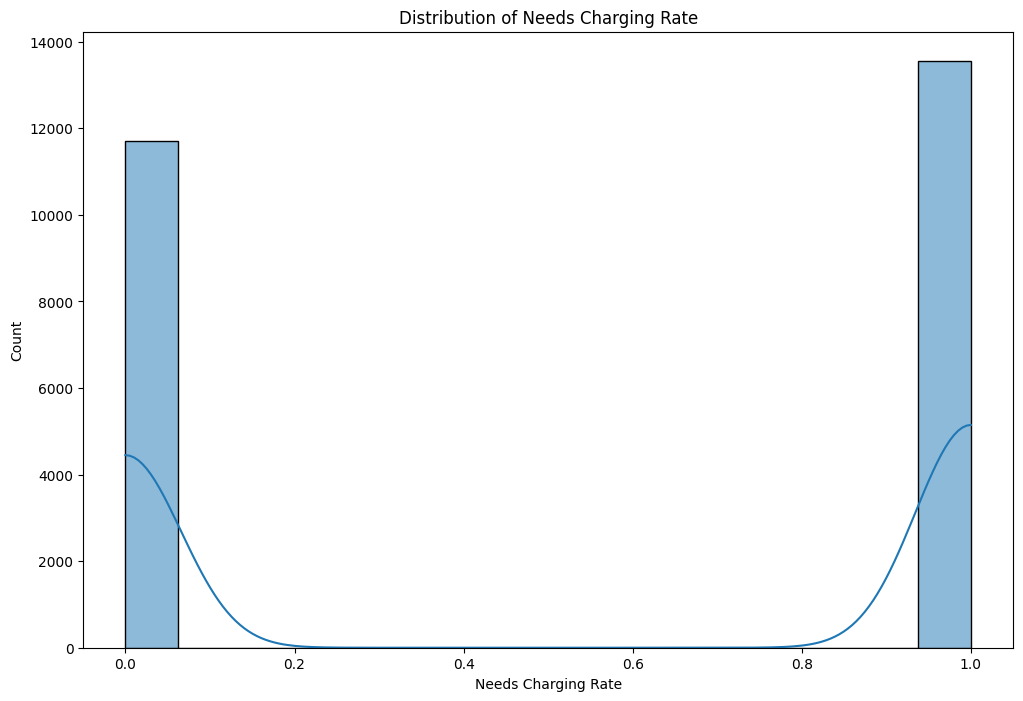

In [14]:
# Distribution of the target variable
plt.figure(figsize=(12,8))
sns.histplot(data['needs_charge'], kde=True)
plt.title('Distribution of Needs Charging Rate')
plt.xlabel('Needs Charging Rate')
plt.ylabel('Count')
plt.show()

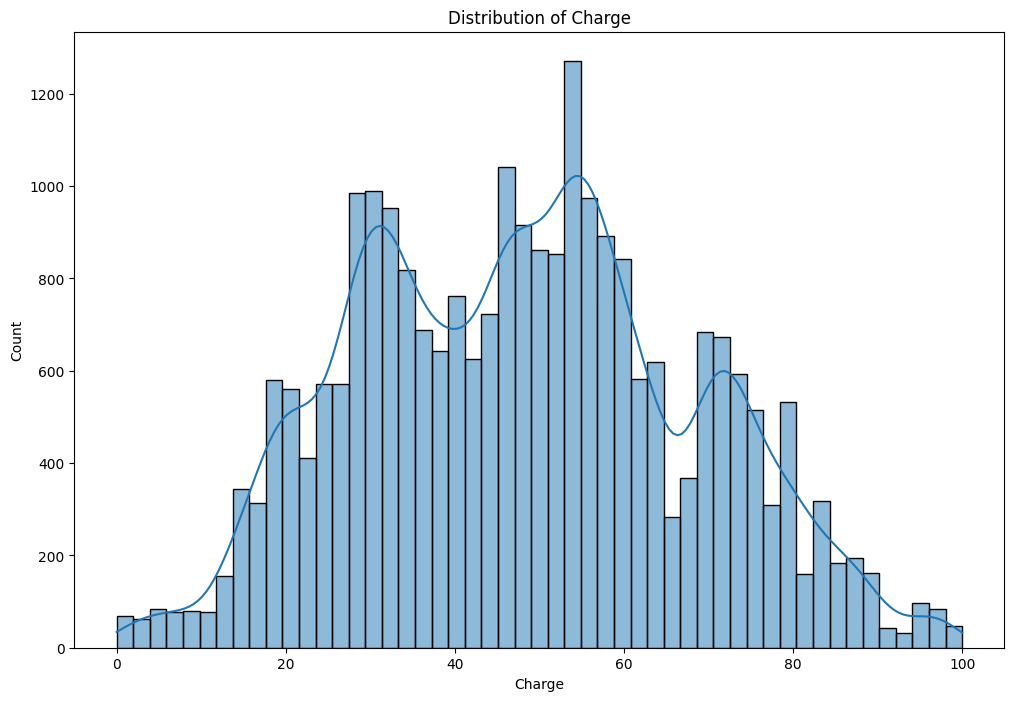

In [15]:
# plot the distribution 
plt.figure(figsize=(12,8))
sns.histplot(data['charge'], kde=True)
plt.title('Distribution of Charge')
plt.xlabel('Charge')
plt.ylabel('Count')
plt.show()


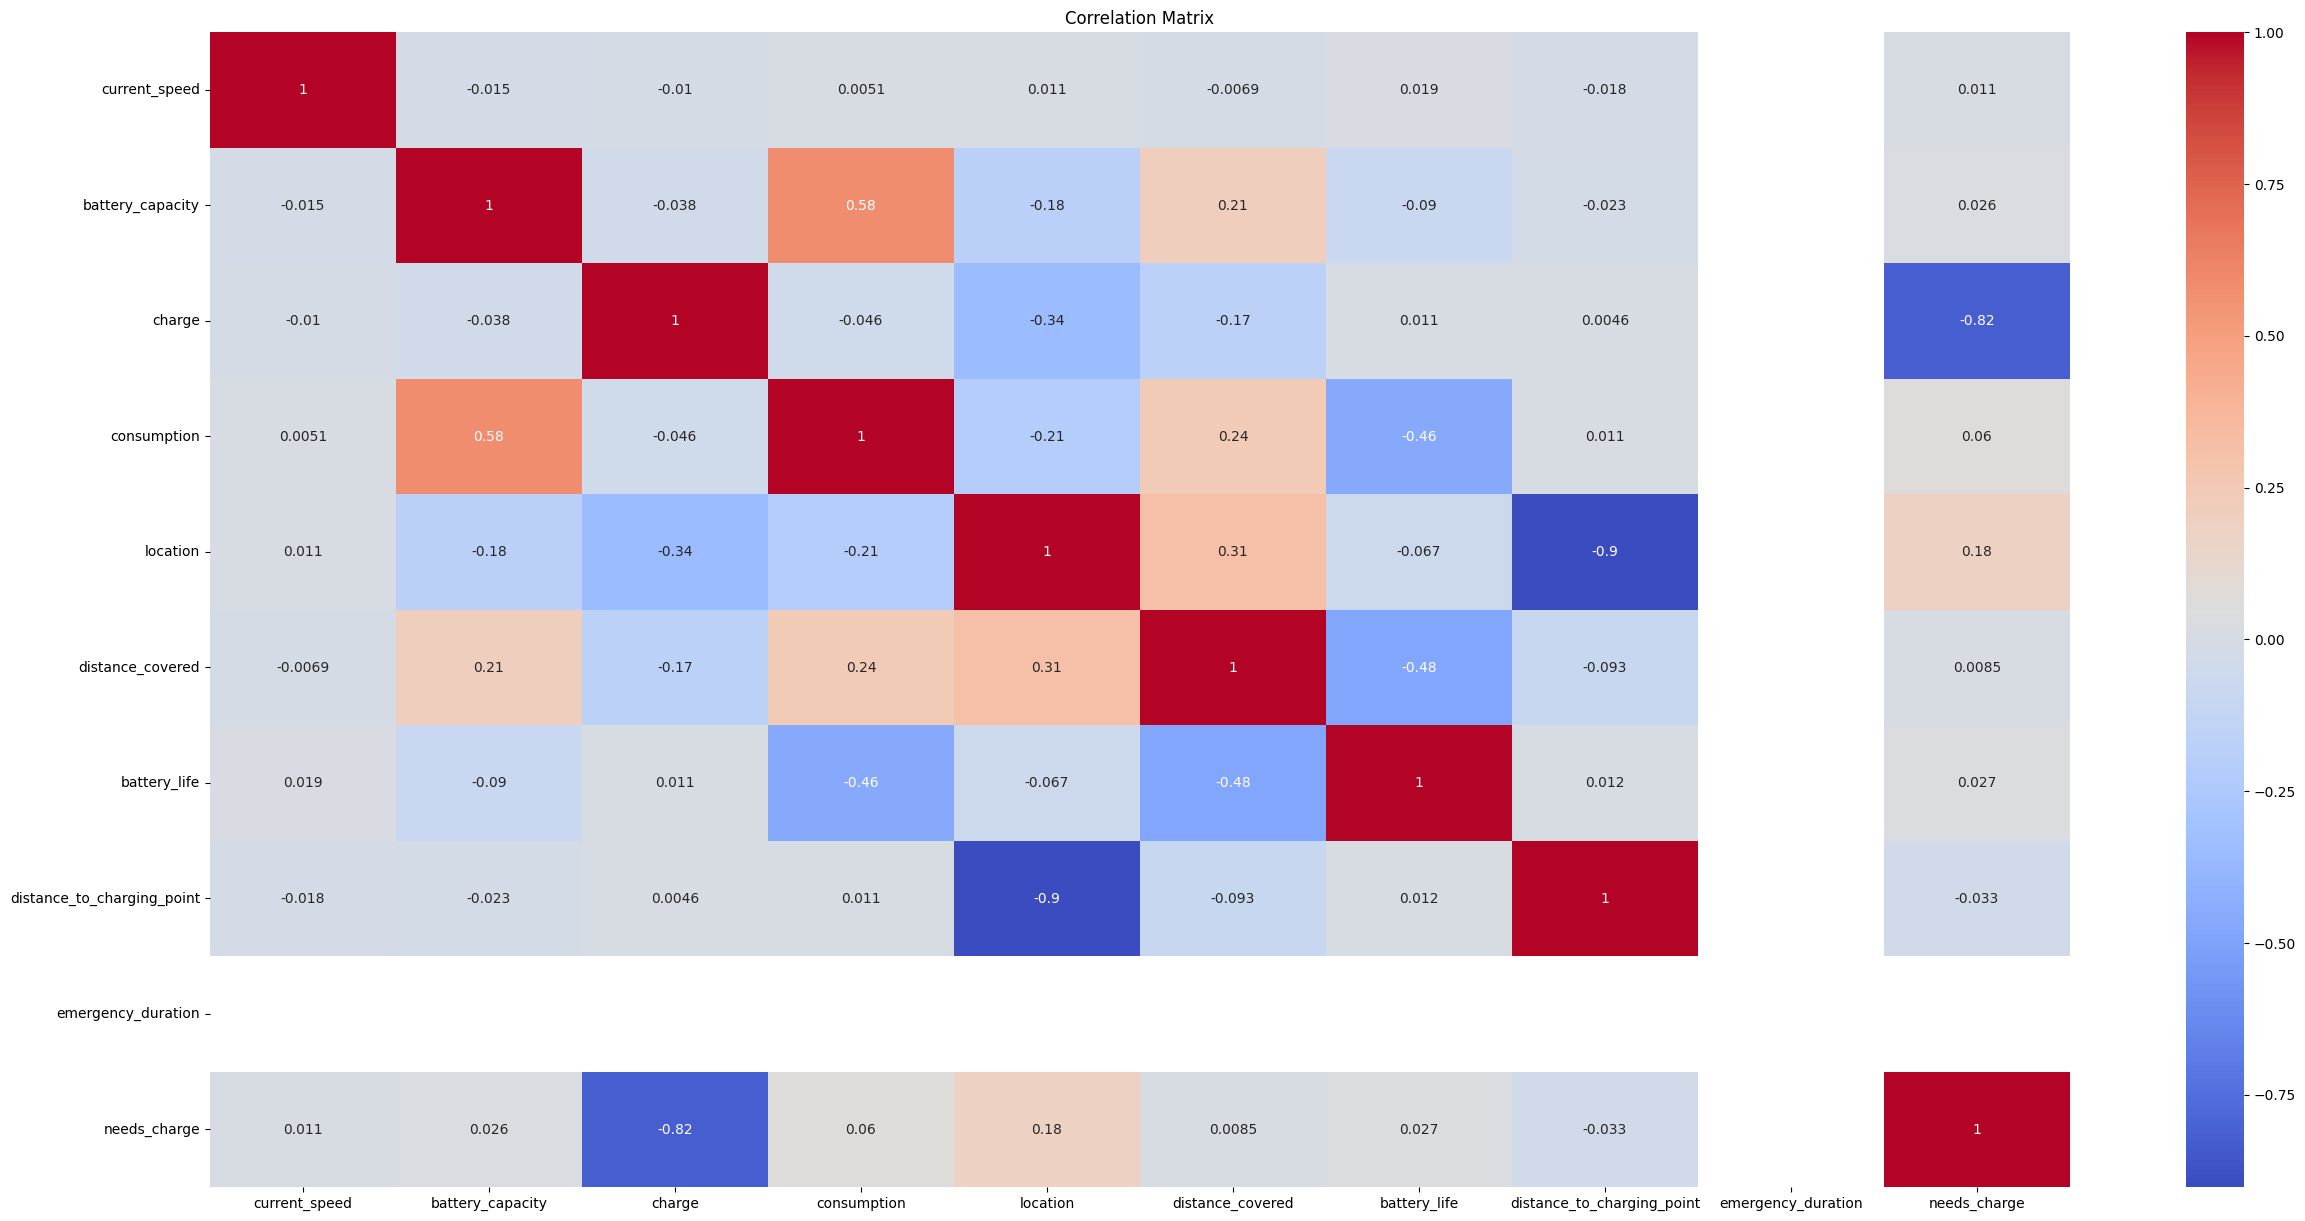

In [16]:
## Correlation Analysis
correlation_matrix = data.corr()
plt.figure(figsize=(30,15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

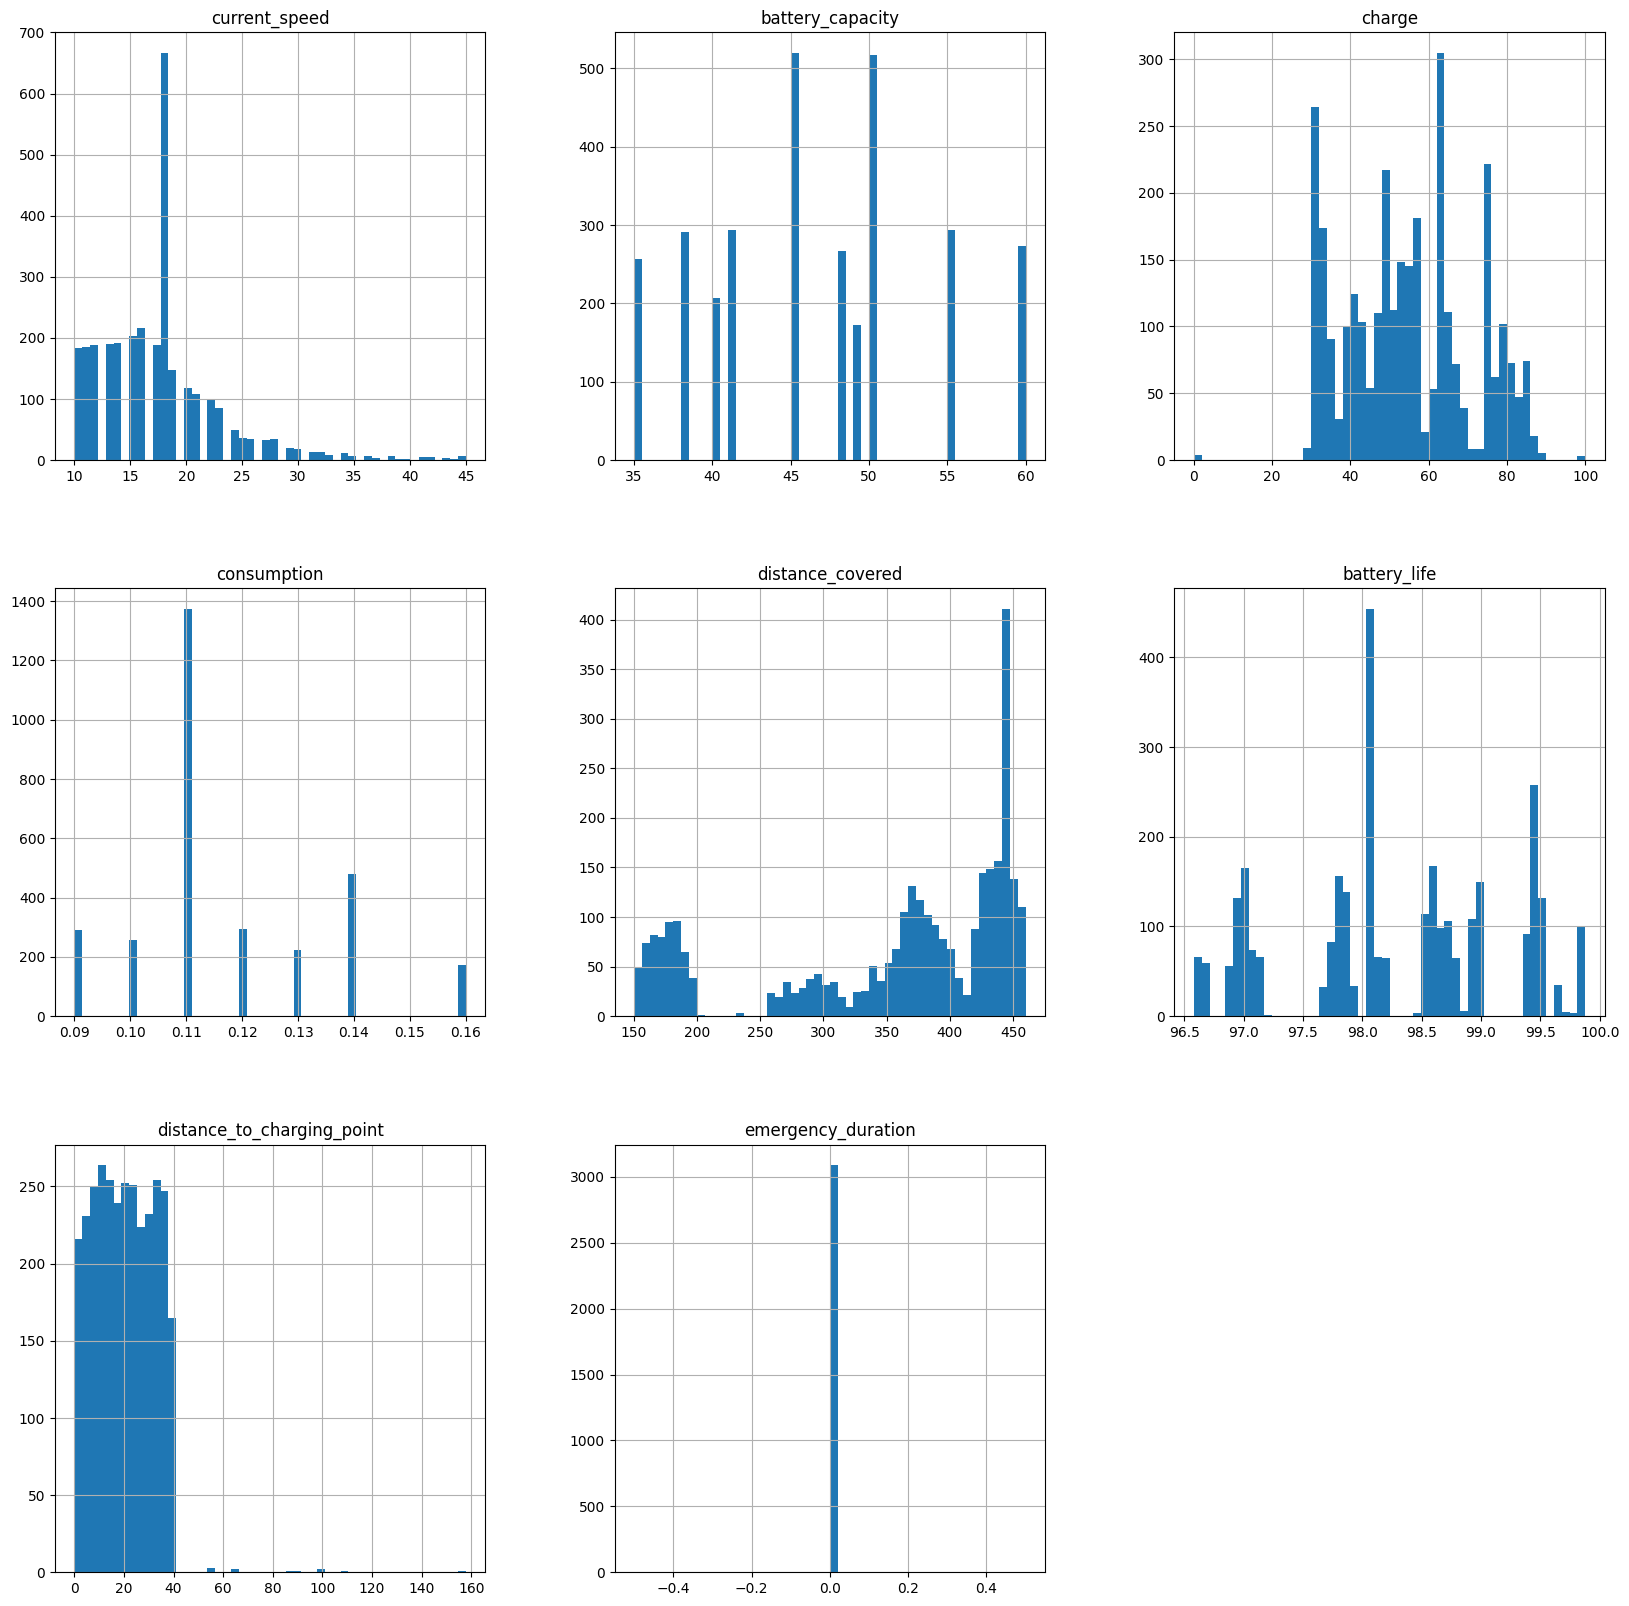

In [17]:
# Visualizing the distribution of the features
# Replace inf with nan
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop nan values
data.dropna(inplace=True)

data[features].hist(figsize=(20, 20), bins=50)
plt.show()

/home/maith/.local/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


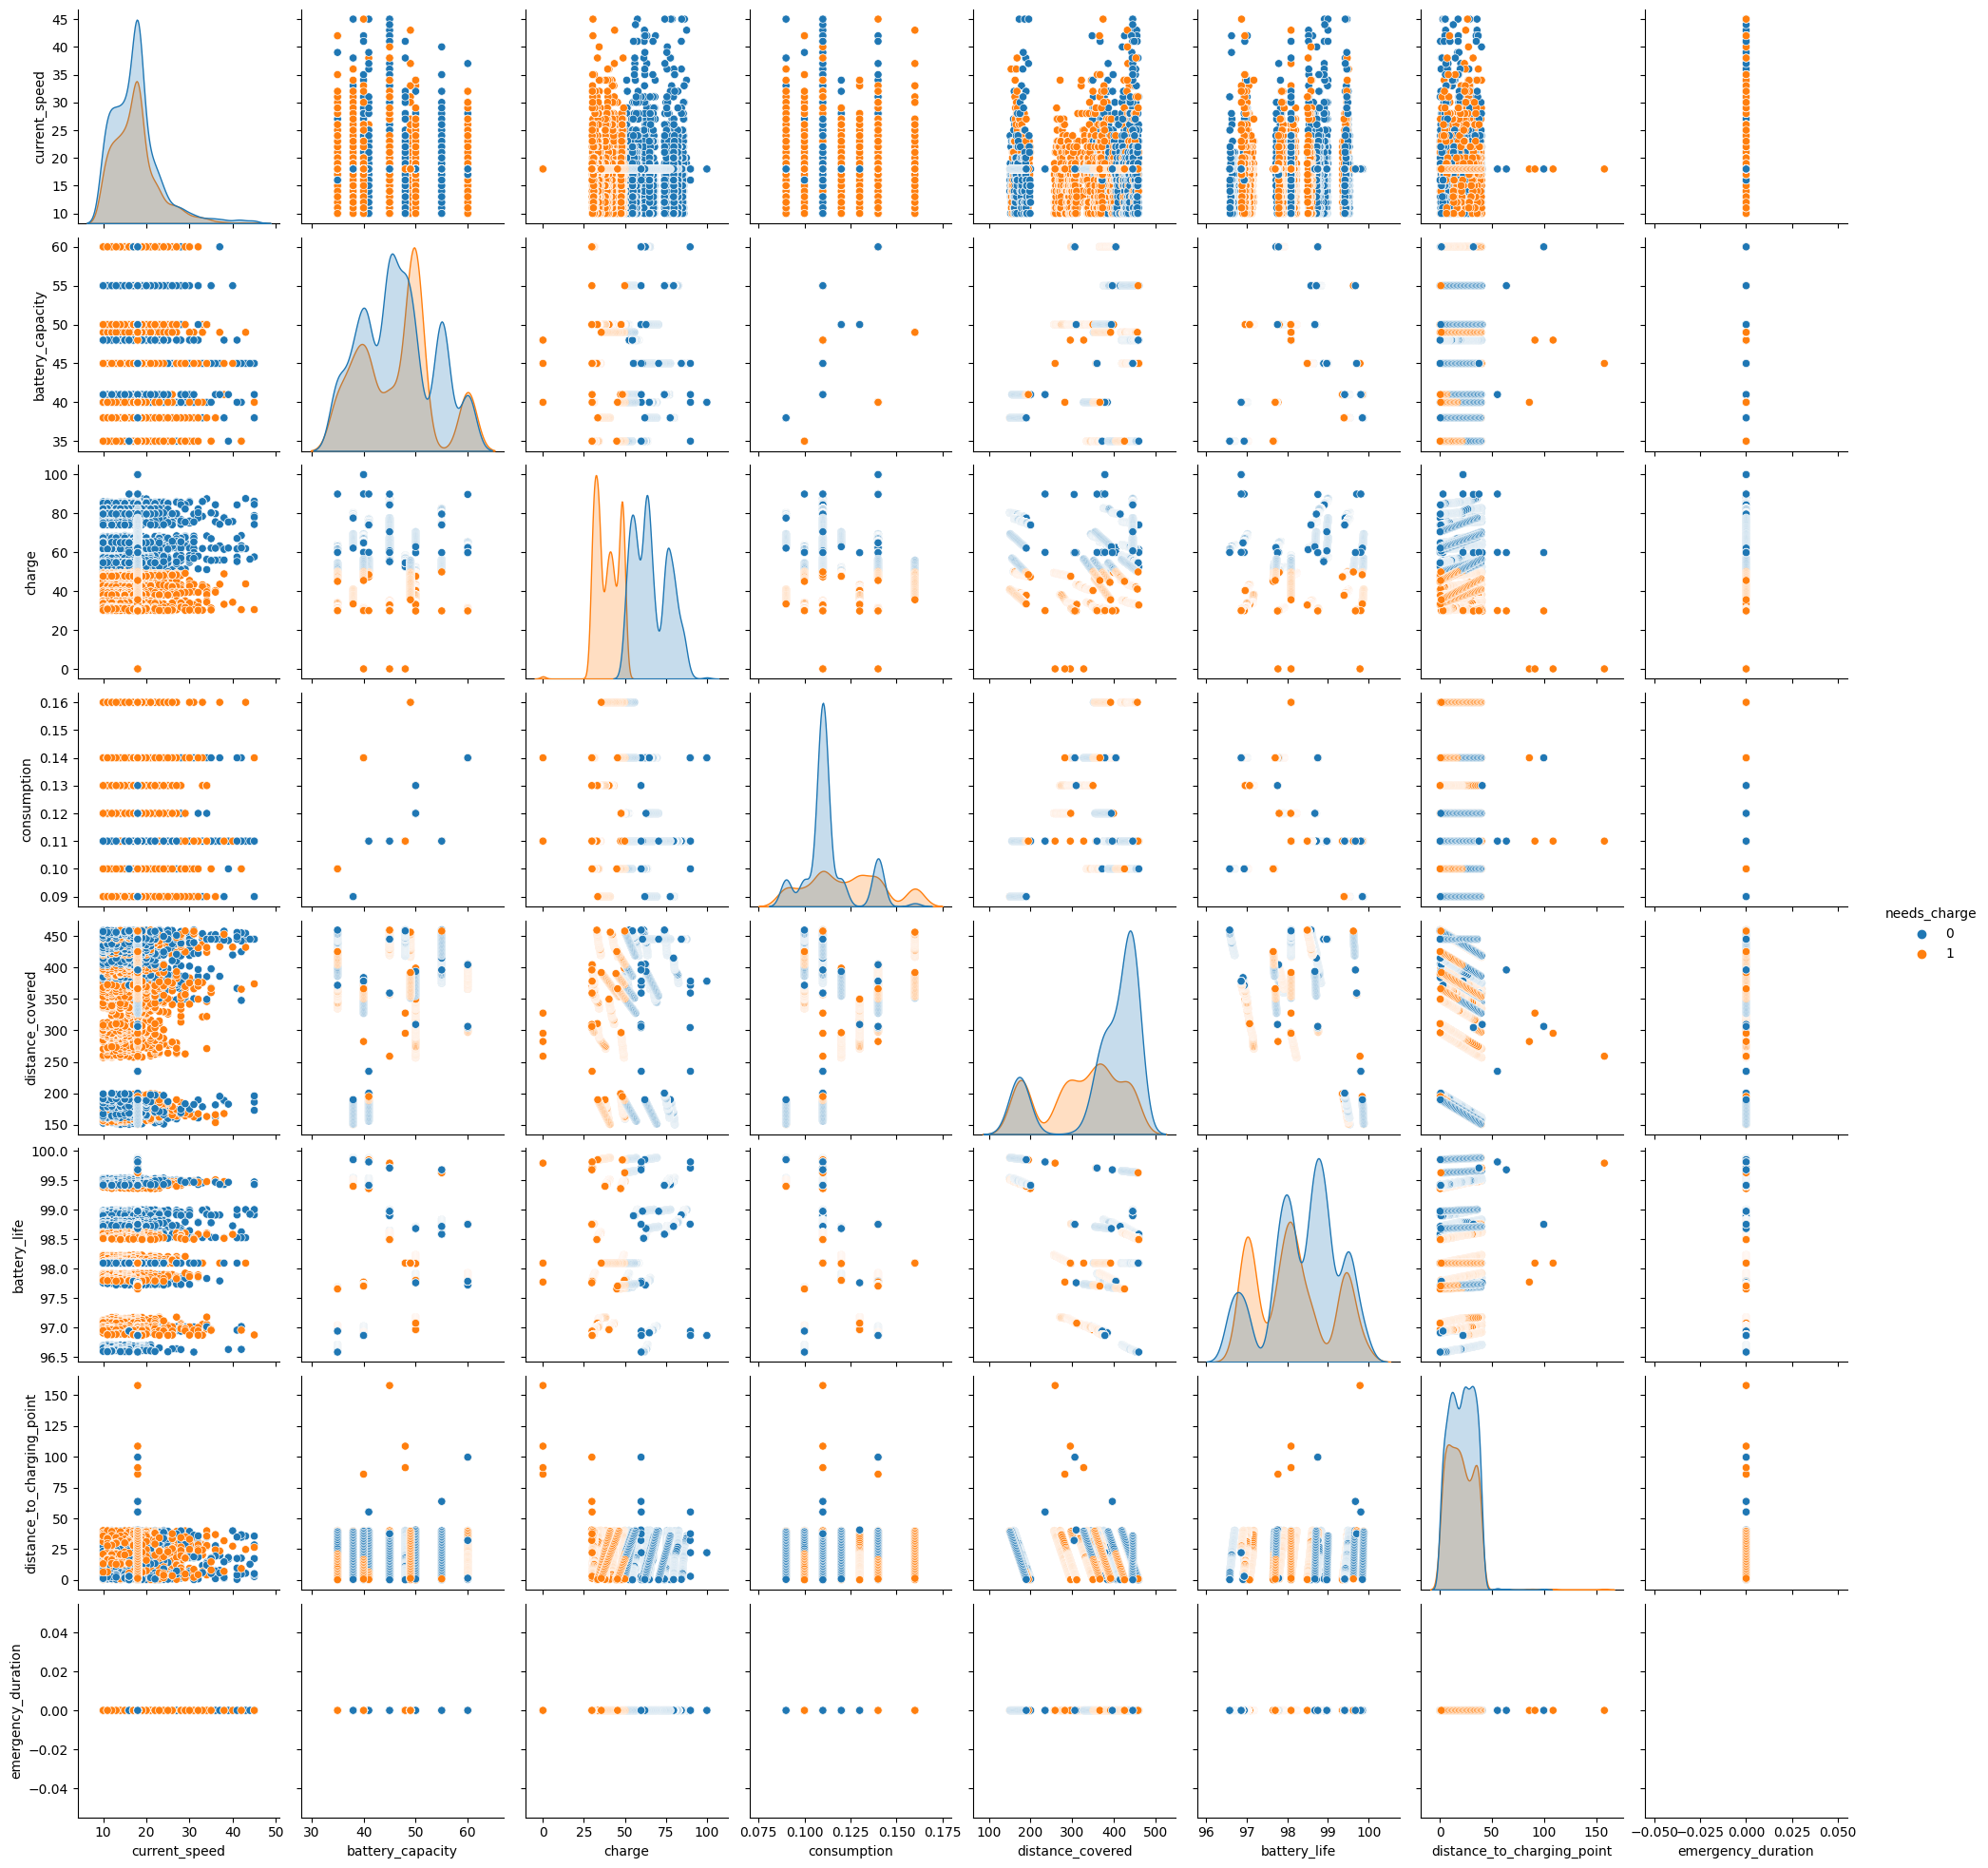

In [18]:
# Pairplot of the features and target variable
sns.pairplot(data[features + ['needs_charge']], hue='needs_charge')
plt.show()

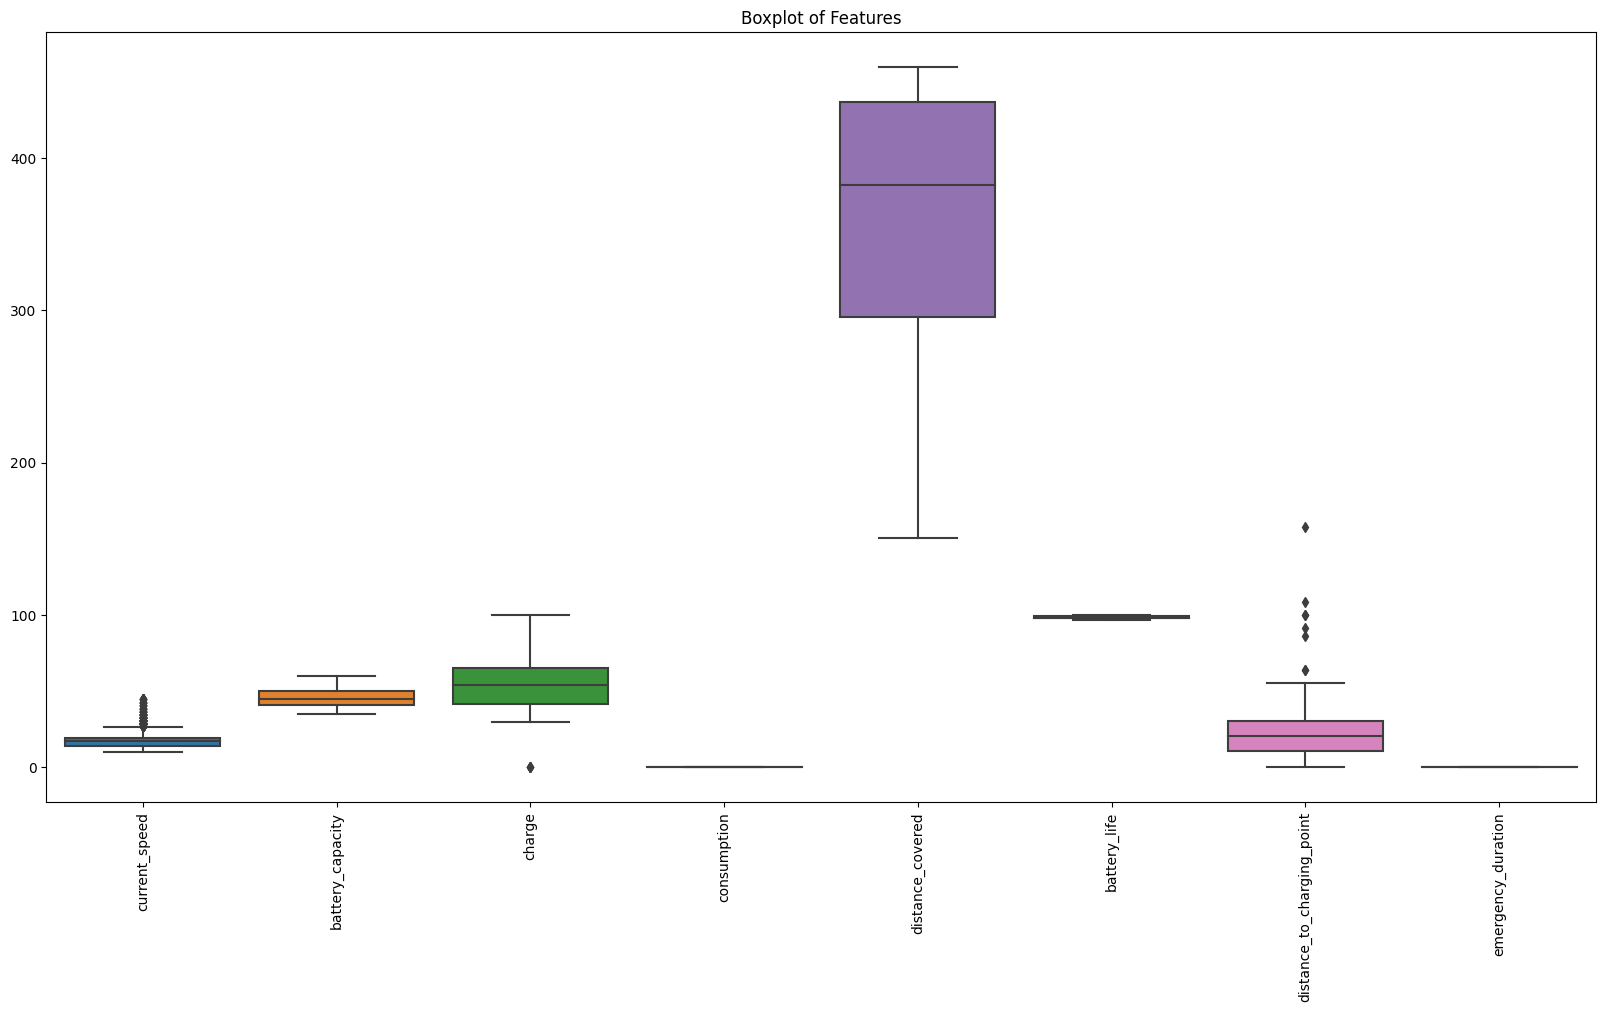

In [19]:
# Boxplots for each feature
plt.figure(figsize=(20, 10))
sns.boxplot(data=data[features])
plt.title('Boxplot of Features')
plt.xticks(rotation=90)
plt.show()

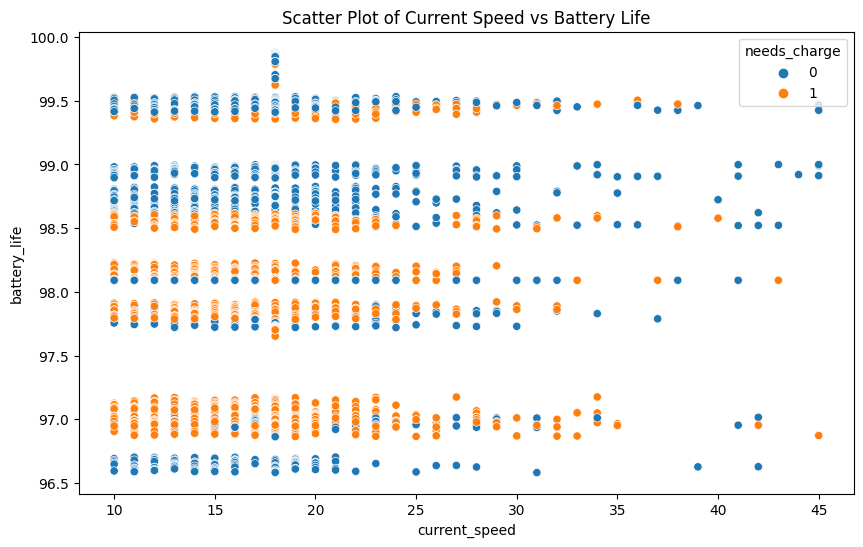

In [20]:
# Scatter plots
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='current_speed', y='battery_life', hue='needs_charge')
plt.title('Scatter Plot of Current Speed vs Battery Life')
plt.show()

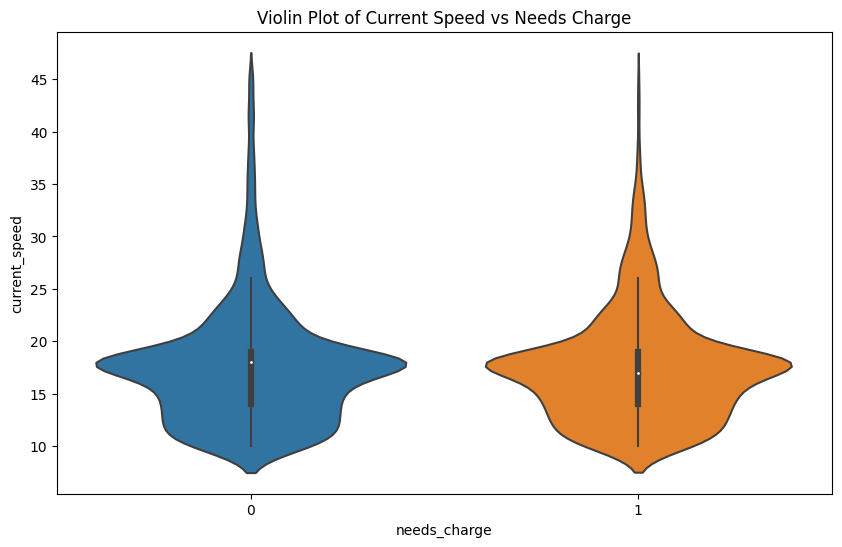

In [21]:
# Violin plots
plt.figure(figsize=(10, 6))
sns.violinplot(x=data['needs_charge'], y=data['current_speed'])
plt.title('Violin Plot of Current Speed vs Needs Charge')
plt.show()

/home/maith/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


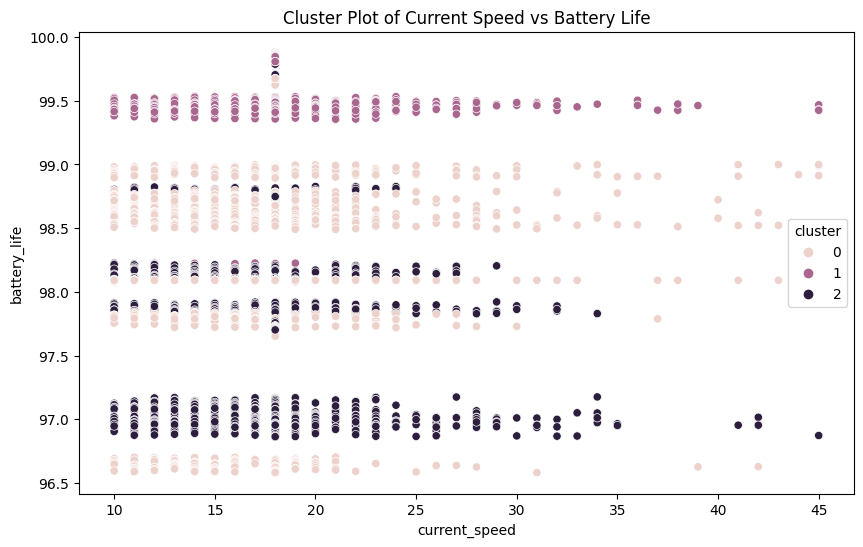

In [22]:
# cluster plot
from sklearn.cluster import KMeans

# Fit the KMeans algorithm to the data
kmeans = KMeans(n_clusters=3)
data['cluster'] = kmeans.fit_predict(data[features])

plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='current_speed', y='battery_life', hue='cluster')
plt.title('Cluster Plot of Current Speed vs Battery Life')
plt.show()

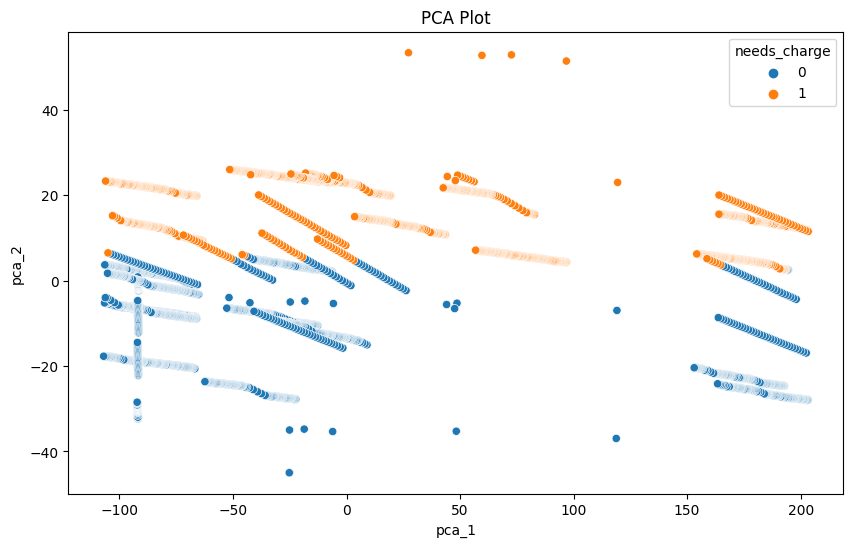

In [23]:
# Dimensionality reduction plot
from sklearn.decomposition import PCA

# Apply PCA to the data
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data[features])
data['pca_1'] = pca_result[:, 0]
data['pca_2'] = pca_result[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='pca_1', y='pca_2', hue='needs_charge')
plt.title('PCA Plot')
plt.show()

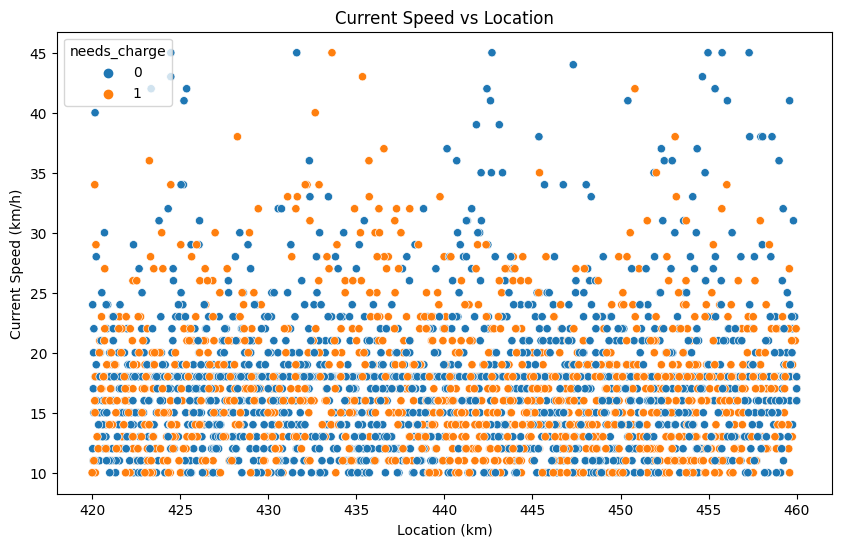

In [24]:
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='location', y='current_speed', hue='needs_charge')
plt.title('Current Speed vs Location')
plt.xlabel('Location (km)')
plt.ylabel('Current Speed (km/h)')
plt.show()

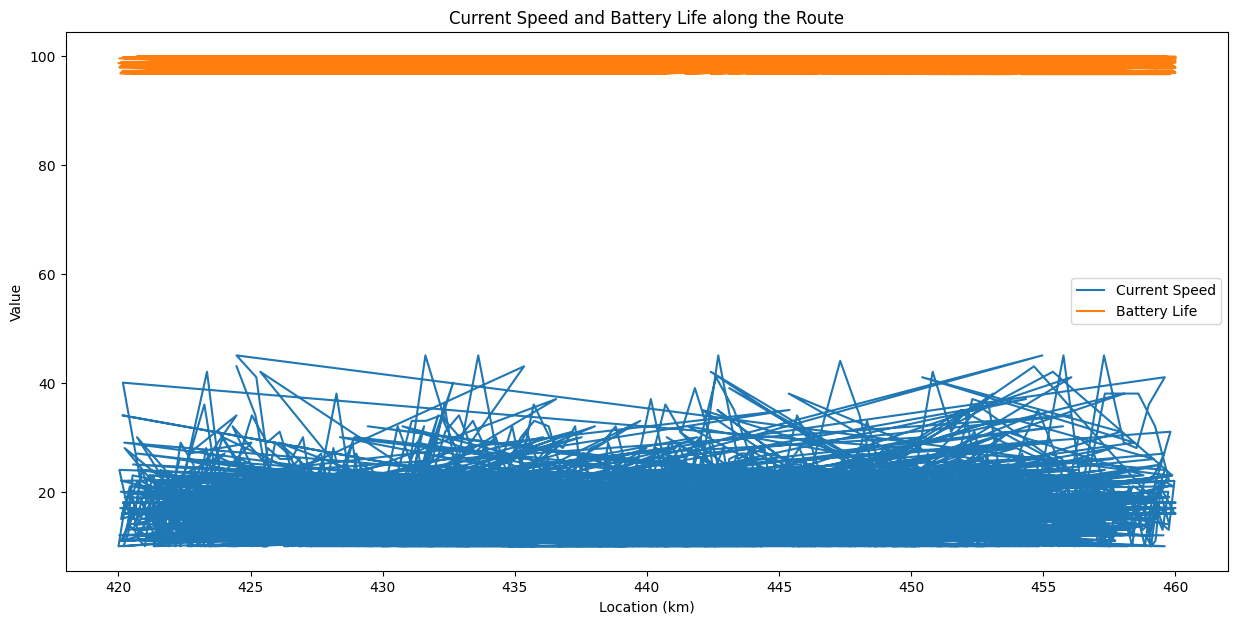

In [25]:
plt.figure(figsize=(15, 7))
plt.plot(data['location'], data['current_speed'], label='Current Speed')
plt.plot(data['location'], data['battery_life'], label='Battery Life')
plt.title('Current Speed and Battery Life along the Route')
plt.xlabel('Location (km)')
plt.ylabel('Value')
plt.legend()
plt.show()

Random Forest Classifier

In [26]:
# Build the model
from sklearn.ensemble import RandomForestClassifier

In [27]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [28]:
# Create a based model
rf = RandomForestClassifier(random_state=42)

In [29]:
# Instantiate the grid search model
from sklearn.model_selection import GridSearchCV


grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [30]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   2.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total tim

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, 40],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300, 400]},
             verbose=2)

In [31]:
# Get the best parameters
best_params = grid_search.best_params_

print("Best Parameters: ", best_params)

Best Parameters:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [32]:
# Train the model with the best parameters
model = grid_search.best_estimator_

In [33]:
# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report

In [34]:
y_pred = model.predict(X_test)

In [35]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 1.00


In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3480
           1       1.00      1.00      1.00      4101

    accuracy                           1.00      7581
   macro avg       1.00      1.00      1.00      7581
weighted avg       1.00      1.00      1.00      7581



In [37]:
# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print(classification_report(y_test, y_pred))

Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3480
           1       1.00      1.00      1.00      4101

    accuracy                           1.00      7581
   macro avg       1.00      1.00      1.00      7581
weighted avg       1.00      1.00      1.00      7581



In [38]:
# %%
from sklearn.model_selection import cross_val_score

# Use cross_val_score function
# Cross-Validation
scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')
print('Cross-Validation Accuracy Scores', scores)
print('Average Cross-Validation Accuracy', scores.mean())


Cross-Validation Accuracy Scores [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Average Cross-Validation Accuracy 1.0


In [39]:
# Initialize the constructor
model = Sequential()

In [40]:
# Add an input layer 
model.add(Dense(12, activation='relu', input_shape=(len(X.columns),)))

In [41]:
# Add one hidden layer 
model.add(Dense(8, activation='relu'))

In [42]:
# Add an output layer 
model.add(Dense(1, activation='sigmoid'))

In [43]:
# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                108       
                                                                 
 dense_1 (Dense)             (None, 8)                 104       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 221
Trainable params: 221
Non-trainable params: 0
_________________________________________________________________


In [45]:
# Define the callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [EarlyStopping(patience=10, restore_best_weights=True),
             ModelCheckpoint(filepath='best_model.h5', save_best_only=True)]

In [46]:
# Fit the model
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, 
          validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/100


553/553 [==============================] - 2s 2ms/step - loss: 0.3715 - accuracy: 0.8548 - val_loss: 0.1002 - val_accuracy: 0.9736
Epoch 2/100
553/553 [==============================] - 1s 1ms/step - loss: 0.0665 - accuracy: 0.9821 - val_loss: 0.0439 - val_accuracy: 0.9896
Epoch 3/100
553/553 [==============================] - 1s 1ms/step - loss: 0.0371 - accuracy: 0.9914 - val_loss: 0.0274 - val_accuracy: 0.9945
Epoch 4/100
553/553 [==============================] - 1s 1ms/step - loss: 0.0259 - accuracy: 0.9943 - val_loss: 0.0201 - val_accuracy: 0.9953
Epoch 5/100
553/553 [==============================] - 1s 1ms/step - loss: 0.0199 - accuracy: 0.9955 - val_loss: 0.0153 - val_accuracy: 0.9967
Epoch 6/100
553/553 [==============================] - 1s 1ms/step - loss: 0.0161 - accuracy: 0.9962 - val_loss: 0.0129 - val_accuracy: 0.9967
Epoch 7/100
553/553 [==============================] - 1s 1ms/step - loss: 0.0135 - accuracy: 0.9970 - val_loss: 0.0112 - val_accuracy: 0.9975
Epoch 8/100

In [47]:
# Evaluate the model
score = model.evaluate(X_test, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

  1/237 [..............................] - ETA: 3s - loss: 2.9570e-07 - accuracy: 1.0000

237/237 [==============================] - 0s 557us/step - loss: 0.0026 - accuracy: 0.9991
Test loss: 0.002629767404869199
Test accuracy: 0.9990766644477844


In [48]:
def predict_need_charge(model, scaler, features):
    # print feature names and their values
       
    # scale the features
    features_scaled = scaler.transform(np.array(features).reshape(1, -1))
    # make prediction
    prediction = model.predict(features_scaled)
    return int(prediction.round())

features = [
    180,  # current_speed
    33,  # battery_capacity
    65,  # charge
    0.2,  # consumption
    400,  # distance_covered
    60,  # battery_life
    80,   # distance_to_charging_point
    0    # emergency_duration
]

prediction = predict_need_charge(model, scaler, features)
if prediction == 1:
    print("The car needs to charge in the next station.")
else:
    print("The car does not need to charge in the next station.")

1/1 [==============================] - 0s 65ms/step
The car does not need to charge in the next station.


/home/maith/.local/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [49]:
# save Random Forest model
joblib.dump(model, 'random_forest_model_node_4.pkl')

# save Neural Network model
model.save('neural_network_model_node_4.h5')

# save scaler object
joblib.dump(scaler, 'scaler_node_4.pkl')

['scaler_node_4.pkl']

In [50]:
# load Random Forest model
model = joblib.load('random_forest_model_node_4.pkl')

# load Neural Network model
model = tf.keras.models.load_model('neural_network_model_node_4.h5')

# load scaler object
scaler = joblib.load('scaler_node_4.pkl')

In [51]:
def predict_need_charge(model, scaler, features):
    # scale the features
    features_scaled = scaler.transform(np.array(features).reshape(1, -1))
    # make prediction
    prediction = model.predict(features_scaled)
    return int(prediction.round())

features = [
    80,  # current_speed
    35,  # battery_capacity
    5,  # charge
    0.1,  # consumption
    100,  # distance_covered
    100,  # battery_life
    5,   # distance_to_charging_point
    0    # emergency_duration
]

prediction = predict_need_charge(model, scaler, features)
if prediction == 1:
    print("The car needs to charge in the next station.")
else:
    print("The car does not need to charge in the next station.")


1/1 [==============================] - 0s 39ms/step
The car needs to charge in the next station.


/home/maith/.local/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
